In [9]:
import pandas as pd
import numpy as np
import geopandas
from aws_helpers import execute_athena_query
import matplotlib.pyplot as plt
%matplotlib inline

results_url = execute_athena_query("select site_id, site_name, lat, lon, avg(temperature) as temperature from weather group by site_id, site_name, lat, lon")
df = pd.read_csv(results_url)

df

Executing: select site_id, site_name, lat, lon, avg(temperature) as temperature from weather group by site_id, site_name, lat, lon
Wait count 0/30
Wait count 1/30
Query succeeded


,site_id,site_name,lat,lon,temperature
0,3002,BALTASOUND,60.749,-0.8540,6.632400
1,3068,LOSSIEMOUTH,57.712,-3.3220,5.324400
2,3214,WALNEY ISLAND,54.125,-3.2570,6.292800
3,3230,REDESDALE CAMP,55.285,-2.2790,3.724900
4,3281,FYLINGDALES,54.362,-0.6730,5.070800
...,...,...,...,...,...
134,3769,CHARLWOOD,51.150,-0.2333,8.191129
135,3853,YEOVILTON,51.006,-2.6400,8.613253
136,3882,HERSTMONCEUX WEST END,50.890,0.3190,8.158943
137,99057,WOBURN,52.017,-0.6000,7.827200


# Raw Scatter plot

Note that the coordinates will look a bit weird, because the earth is round ;)

<AxesSubplot:xlabel='lon', ylabel='lat'>

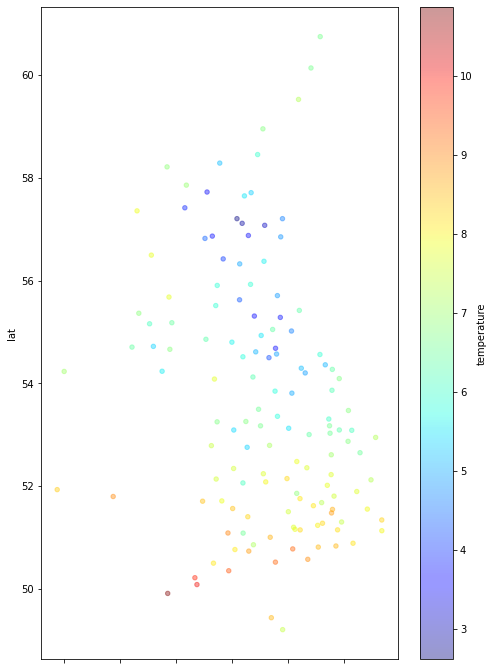

In [10]:
df.plot(
    kind="scatter",
    x="lon", y="lat",
    figsize=(8,12),
    cmap=plt.get_cmap("jet"),
    c='temperature',
    colorbar=True, alpha=0.4
)

# Raw Scatter Plot with OSGB Coords

How to convert coords to OSGB Eastings and Northings

In [11]:
from OSGridConverter import latlong2grid

def convert(r):
    g=latlong2grid(r['lat'], r['lon'])
    r['osgb_E'] = g.E
    r['osgb_N'] = g.N
    return r

osgb = df.apply(convert, axis=1)

osgb

,site_id,site_name,lat,lon,temperature,osgb_E,osgb_N
0,3002,BALTASOUND,60.749,-0.8540,6.632400,462571,1207872
1,3068,LOSSIEMOUTH,57.712,-3.3220,5.324400,321331,869902
2,3214,WALNEY ISLAND,54.125,-3.2570,6.292800,317948,470635
3,3230,REDESDALE CAMP,55.285,-2.2790,3.724900,382377,599021
4,3281,FYLINGDALES,54.362,-0.6730,5.070800,486325,497086
...,...,...,...,...,...,...,...
134,3769,CHARLWOOD,51.150,-0.2333,8.191129,523664,140454
135,3853,YEOVILTON,51.006,-2.6400,8.613253,355192,123152
136,3882,HERSTMONCEUX WEST END,50.890,0.3190,8.158943,563199,112618
137,99057,WOBURN,52.017,-0.6000,7.827200,496171,236322


# geopandas

*geopandas* creates some nice static figures, perfect for using in docs and articles.  You can use vector data from shape files, as per the first example below (which looks a bit 1980's because of the very low res shape data) or you can use a `geotiff` image as a background as per the second example.

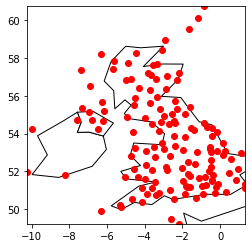

In [12]:
gdf = geopandas.GeoDataFrame(df, geometry=geopandas.points_from_xy(df.lon, df.lat))

# Could load a different shape file here!
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

ax = world[world.continent == 'Europe'].plot(color='white', edgecolor='black')

bounds = gdf.geometry.total_bounds
xlim = ([bounds[0],  bounds[2]])
ylim = ([bounds[1],  bounds[3]])
ax.set_xlim(xlim)
ax.set_ylim(ylim)

gdf.plot(ax=ax, color='red')

plt.show()

<AxesSubplot:title={'center':'UK Weather Stations'}>

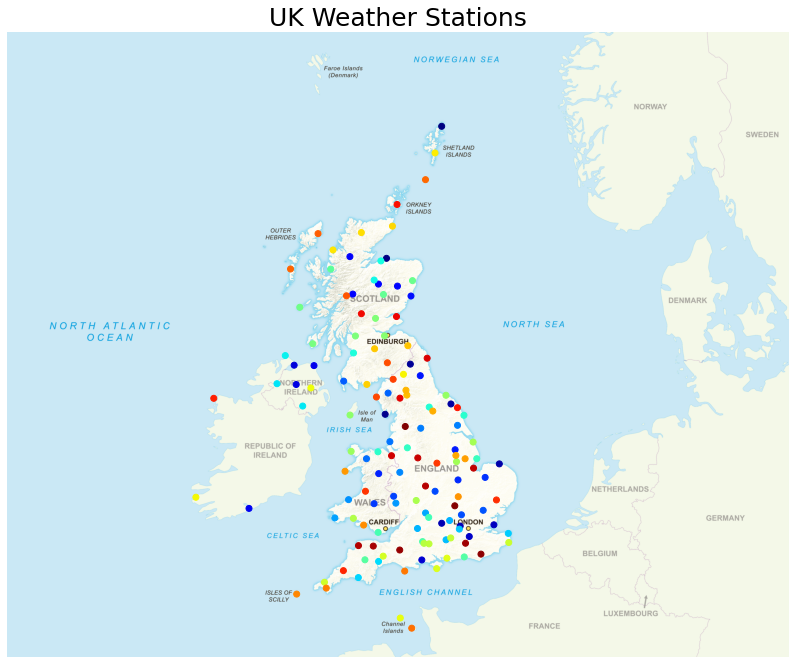

In [13]:
import rasterio.plot

gdf_osgb = geopandas.GeoDataFrame(osgb, geometry=geopandas.points_from_xy(osgb.osgb_E, osgb.osgb_N))

raster_data = rasterio.open('GBOverview.tif', masked=True)
extent=[raster_data.bounds[0], raster_data.bounds[2], raster_data.bounds[1], raster_data.bounds[3]]

f, ax = plt.subplots(figsize=(14, 14))
ax.set_title('UK Weather Stations', fontdict={'fontsize': '25', 'fontweight' : '3'})
ax.set_axis_off()

rasterio.plot.show(raster_data, ax=ax, extent=extent)
gdf_osgb.plot(ax=ax, cmap=plt.get_cmap("jet"), c='temperature')


# Folium

Another python library that wraps Leaflet.  Unlike ipyleaflet, it works in PyCharm's notebook editor.  However, because the output is a big chunk of interactive JS, you don't see the output on platforms like github - so what you gain in interactivity, you lose in shareability.

In [14]:
import folium
from branca.element import Figure

fig=Figure(width=600,height=800)

mid_lat = df['lat'].mean()
mid_lon = df['lon'].mean()

m = folium.Map(location=[mid_lat, mid_lon], tiles = 'Stamen Terrain', zoom_start=6)

df['marker_color'] = pd.cut(df['temperature'], bins=4, labels=['#5599DD', '#55DD55', '#FFAA66', '#DD6666'])

for index, row in df.iterrows():
    folium.CircleMarker(location=(row['lat'], row['lon']), radius=4, weight=2, color=row['marker_color'], fill_color=row['marker_color'], fill_opacity=0.7).add_to(m)

fig.add_child(m)
m